In [11]:
import numpy as np
from random import normalvariate as nv
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output

In [12]:
uint_32_max = 4294967295
def generate_sequence(length=25):
    temp = np.random.sample(length) * uint_32_max
    return temp.astype('uint')

In [13]:
def encode(sequence):
    enc = np.zeros((len(sequence), 32))
    for i in range(len(sequence)):
        bin_num = str(bin(sequence[i]))[2:]
        for ind, bit in enumerate(bin_num[::-1]):
            enc[i, ind] = int(bit)
    return enc
def encode_item(item):
    enc = np.zeros(32)
    bin_num = str(bin(item))[2:]
    for ind, bit in enumerate(bin_num[::-1]):
        enc[ind] = int(bit)
    return enc

In [14]:
encode_item(31)

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
def decode(encoded_seq):
    temp = [0] * len(encoded_seq)
    for i, s in enumerate(encoded_seq):
        for j, num in enumerate(s):
            if num > 0.5:
                temp[i] += (2**(j))
                
    return np.array(temp)

In [16]:
tt = generate_sequence()
assert (tt == decode(encode(tt))).all()

In [17]:
def create_dataset(dataset, look_back=10, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        y = dataset[i + look_back : (i + look_back + look_forward)]
        dataY.append(y)
    return torch.tensor(dataX), torch.tensor(dataY)

In [69]:
class Dataset():
    def __init__(self):
        self.datas = generate_sequence(3000)
        self.c=0
    def __getitem__(self, index):
        temp = self.datas[index]
        temp = encode_item(temp)
        return temp
        
    def __len__(self):
        return len(self.datas) - 1
data = Dataset()
dataloader = DataLoader(data,num_workers=0,batch_size=25, shuffle=False)


In [70]:
class myLSTM(nn.Module):    
    def __init__(self, hidden_dim):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(10, hidden_dim, 2).cuda()
        self.linear = nn.Sequential(nn.Linear(hidden_dim, 1)).cuda()
        self.hidden = (Variable(torch.zeros(2, 1, self.hidden_dim), requires_grad=False).cuda(),
                  Variable(torch.zeros(2, 1, self.hidden_dim), requires_grad=False).cuda())
    def forward(self, inp):
        self.lstm.train()
        self.linear.train()
        lstm_out, _ = self.lstm(inp)
#         print(lstm_out.shape)
        out = self.linear(lstm_out)
        return torch.nn.functional.sigmoid(out)
    def generate(self, inp):
        self.lstm.eval()
        self.linear.eval()
        lstm_out, temp= self.lstm(inp, self.hidden)
        lstm_out = lstm_out.detach()
        temp1, temp2 = temp
        self.hidden = (temp1.detach(), temp2.detach())
        out = self.linear(lstm_out)
        return torch.nn.functional.sigmoid(out)
    

In [1]:
loss = nn.BCELoss()
network = myLSTM(300).to('cuda')
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)


for epoch in range(2000):
    ep_losses = [] 
    for ss in dataloader:
        ss = np.array(ss)
        X, y = create_dataset(ss)
        X = Variable(X.transpose(0, 2).transpose(1, 2)).float().cuda()
        y = Variable(y).float().cuda()
        prediction = network(X)
        prediction = prediction.transpose(0, 1).transpose(1, 2)
        loss_batch = loss(prediction, y)
        
        loss_batch.backward()
        optimizer.step()
        
        ep_losses.append(loss_batch.data.cpu().item())
        
    print(epoch, np.array(ep_losses).mean())

In [54]:
def generate(network, gen_len = 10):
    mas = list(generate_sequence(20))
    for i in range(gen_len):
        ss = encode(mas[-10:])
        tens = torch.tensor(ss)
        tens = tens.reshape(32, 1, -1)
        el = Variable(tens, requires_grad=False).float().cuda()
        pred = network.generate(el).detach().cpu().flatten()
#         print(pred)
        mas.append(decode(pred.reshape(1, -1)).item())
    return mas[20:]

In [55]:
i=6
np.random.seed(i)
torch.random.manual_seed(i)

In [56]:
res = generate(network, gen_len= 2000000)

2000000

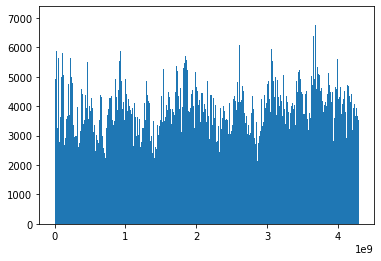

In [57]:
plt.hist(res, 500)
len(res)

In [58]:
with open('res3.txt', 'w') as f:
    for i in res:
        f.write(str(i) + '\n')